# AGH DS Laboratory 3 - Actor Model with Ray Framework

## Introduction

Ray is a general-purpose framework for programming a cluster made by UC Berkeley's RISELab. It enables developers to easily parallelize their Python applications or build new ones, and run them at any scale, from a laptop to a large cluster. It also provides a highly flexible, yet minimalist and easy to use API. 

#### Documentation Reference Links:

Ray official website: https://rise.cs.berkeley.edu/projects/ray/

Ray documentation website: http://ray.readthedocs.io/en/latest/

GitHub repository: https://github.com/ray-project/ray

### Installation
Please follow the instructions:

Installation: https://docs.ray.io/en/latest/ray-overview/installation.html


***
## Part 1 - Remote Functions

This script is too slow, and the computation is embarrassingly parallel. In this exercise, you will use Ray to execute the functions in parallel to speed it up.

The standard way to turn a Python function into a remote function is to add the `@ray.remote` decorator. Here is an example.

```python
# A regular Python function.
def regular_function(x):
    return x + 1

# A Ray remote function.
@ray.remote
def remote_function(x):
    return x + 1
```

The differences are the following:

1. **Invocation:** The regular version is called with `regular_function(1)`, whereas the remote version is called with `remote_function.remote(1)`.
2. **Return values:** `regular_function` immediately executes and returns `1`, whereas `remote_function` immediately returns an object ID (a future) and then creates a task that will be executed on a worker process. The result can be obtained with `ray.get`.
    ```python
    >>> regular_function(0)
    1
    
    >>> remote_function.remote(0)
    ObjectID(1c80d6937802cd7786ad25e50caf2f023c95e350)
    
    >>> ray.get(remote_function.remote(0))
    1
    ```
3. **Parallelism:** Invocations of `regular_function` happen **serially**, for example
    ```python
    # These happen serially.
    for _ in range(4):
        regular_function(0)
    ```
    whereas invocations of `remote_function` happen in **parallel**, for example
    ```python
    # These happen in parallel.
    for _ in range(4):
        remote_function.remote(0)
    ```

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ray
import time
import numpy as np
from numpy import random
import os
import pickle
import matplotlib.pyplot as plt

Start Ray. By default, Ray does not schedule more tasks concurrently than there are CPUs. This example requires four tasks to run concurrently, so we tell Ray that there are four CPUs. Usually this is not done and Ray computes the number of CPUs using `psutil.cpu_count()`. The argument `ignore_reinit_error=True` just ignores errors if the cell is run multiple times.

The call to `ray.init` starts a number of processes.

In [2]:
if ray.is_initialized:
    ray.shutdown()
ray.init(ignore_reinit_error=True)

2025-05-12 02:58:51,798	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.44.1
Dashboard:,http://127.0.0.1:8265


(slow_function pid=316720) Running in pid 316720


(generate_fibonacci_distributed pid=316712) /tmp/ipykernel_316370/3006368344.py:10: RuntimeWarning: overflow encountered in scalar add
(generate_fibonacci_distributed pid=316724) /tmp/ipykernel_316370/3006368344.py:10: RuntimeWarning: overflow encountered in scalar add


(raylet) WARNING: 64 PYTHON worker processes have been started on node: b817a5eda882a13a2d48ef728f412db257b4266a96398d90ea0fe61d with address: 172.24.109.133. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


In [3]:
# This function is a proxy for a more interesting and computationally
# intensive function.
@ray.remote
def slow_function(i):
    print(f"Running in pid {os.getpid()}")
    time.sleep(1)
    return i

**EXERCISE:** The loop below takes too long. The four function calls could be executed in parallel. Instead of four seconds, it should only take one second. Once `slow_function` has been made a remote function, execute these four tasks in parallel by calling `slow_function.remote()`. Then obtain the results by calling `ray.get` on a list of the resulting object IDs.

In [4]:
# Sleep a little to improve the accuracy of the timing measurements below.
# We do this because workers may still be starting up in the background.
time.sleep(2.0)
start_time = time.time()

results = ray.get([slow_function.remote(i) for i in range(4)])

end_time = time.time()
duration = end_time - start_time

print(
    "The results are {}. This took {} seconds. Run the next cell to see "
    "if the exercise was done correctly.".format(results, duration)
)

The results are [0, 1, 2, 3]. This took 1.0631811618804932 seconds. Run the next cell to see if the exercise was done correctly.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [5]:
assert results == [0, 1, 2, 3], "Did you remember to call ray.get?"
assert duration < 1.1, "The loop took {} seconds. This is too slow.".format(duration)
assert duration > 1, "The loop took {} seconds. This is too fast.".format(duration)

print("Success! The example took {} seconds.".format(duration))

Success! The example took 1.0631811618804932 seconds.


**Example Generating Fibonnaci series**
Let's define two functions: one runs locally or serially, the other runs on a Ray cluster (local or remote). Please implment it

In [6]:
# Function for local fibonacci computation
def generate_fibonacci(sequence_size):
    # return length of table with generated fibonnachi numbers
    # do not use recursion, reuse allocated table
    # DO NOT RETURN ENTIRE
    fib = np.zeros(sequence_size, dtype=np.int64)
    fib[0] = 0
    fib[1] = 1
    for i in range(2, sequence_size):
        fib[i] = fib[i - 1] + fib[i - 2]
    return len(fib)


# Function for remote Ray task with just a wrapper
@ray.remote
def generate_fibonacci_distributed(sequence_size):
    return generate_fibonacci(sequence_size)

In [7]:
# Get the number of cores for better parralelism
os.cpu_count()

16

In [8]:
# Normal Python in a single process
def run_local(sequence_size):
    results = [generate_fibonacci(sequence_size) for _ in range(os.cpu_count())]
    return results


SEQUENCE_SIZE = 100000
%time run_local(SEQUENCE_SIZE)


/tmp/ipykernel_316370/3006368344.py:10: RuntimeWarning: overflow encountered in scalar add
  fib[i] = fib[i - 1] + fib[i - 2]


CPU times: user 475 ms, sys: 25.8 ms, total: 501 ms
Wall time: 548 ms


[100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000]

In [9]:
# Distributed on a Ray cluster
def run_remote(sequence_size):
    results = ray.get(
        [
            generate_fibonacci_distributed.remote(sequence_size)
            for _ in range(os.cpu_count())
        ]
    )
    return results


%time run_remote(SEQUENCE_SIZE)

CPU times: user 0 ns, sys: 25.9 ms, total: 25.9 ms
Wall time: -2.71e+09 ns


[100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000]

***
## Part 2 - Parallel Data Processing with Task Dependencies

**GOAL:** The goal of this exercise is to show how to pass object IDs into remote functions to encode dependencies between tasks.

In this exercise, we construct a sequence of tasks each of which depends on the previous mimicking a data parallel application. Within each sequence, tasks are executed serially, but multiple sequences can be executed in parallel.

In this exercise, you will use Ray to parallelize the computation below and speed it up.

### Concept for this Exercise - Task Dependencies

Suppose we have two remote functions defined as follows.

```python
@ray.remote
def f(x):
    return x
```

Arguments can be passed into remote functions as usual.

```python
>>> x1_id = f.remote(1)
>>> ray.get(x1_id)
1

>>> x2_id = f.remote([1, 2, 3])
>>> ray.get(x2_id)
[1, 2, 3]
```

**Object IDs** can also be passed into remote functions. When the function actually gets executed, **the argument will be a retrieved as a regular Python object**.

```python
>>> y1_id = f.remote(x1_id)
>>> ray.get(y1_id)
1

>>> y2_id = f.remote(x2_id)
>>> ray.get(y2_id)
[1, 2, 3]
```

So when implementing a remote function, the function should expect a regular Python object regardless of whether the caller passes in a regular Python object or an object ID.

**Task dependencies affect scheduling.** In the example above, the task that creates `y1_id` depends on the task that creates `x1_id`. This has the following implications.

- The second task will not be executed until the first task has finished executing.
- If the two tasks are scheduled on different machines, the output of the first task (the value corresponding to `x1_id`) will be copied over the network to the machine where the second task is scheduled.


These are some helper functions that mimic an example pattern of a data parallel application.

**EXERCISE:** You will need to turn all of these functions into remote functions. When you turn these functions into remote function, you do not have to worry about whether the caller passes in an object ID or a regular object. In both cases, the arguments will be regular objects when the function executes. This means that even if you pass in an object ID, you **do not need to call `ray.get`** inside of these remote functions.

In [10]:
@ray.remote
def load_data(filename):
    time.sleep(0.1)
    return np.ones((1000, 100))


@ray.remote
def normalize_data(data):
    time.sleep(0.1)
    return data - np.mean(data, axis=0)


@ray.remote
def extract_features(normalized_data):
    time.sleep(0.1)
    return np.hstack([normalized_data, normalized_data**2])


@ray.remote
def compute_loss(features):
    num_data, dim = features.shape
    time.sleep(0.1)
    return np.sum((np.dot(features, np.ones(dim)) - np.ones(num_data)) ** 2)


assert hasattr(load_data, "remote"), "load_data must be a remote function"
assert hasattr(normalize_data, "remote"), "normalize_data must be a remote function"
assert hasattr(extract_features, "remote"), "extract_features must be a remote function"
assert hasattr(compute_loss, "remote"), "compute_loss must be a remote function"

**EXERCISE:** The loop below takes too long. Parallelize the four passes through the loop by turning `load_data`, `normalize_data`, `extract_features`, and `compute_loss` into remote functions and then retrieving the losses with `ray.get`.

**NOTE:** You should only use **ONE** call to `ray.get`. For example, the object ID returned by `load_data` should be passed directly into `normalize_data` without needing to be retrieved by the driver.

In [11]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

losses = []
for filename in ["file1", "file2", "file3", "file4"]:
    inner_start = time.time()

    data = load_data.remote(filename)
    normalized_data = normalize_data.remote(data)
    features = extract_features.remote(normalized_data)
    loss = compute_loss.remote(features)
    losses.append(loss)

    inner_end = time.time()

    if inner_end - inner_start >= 0.1:
        raise Exception(
            "You may be calling ray.get inside of the for loop! "
            "Doing this will prevent parallelism from being exposed. "
            "Make sure to only call ray.get once outside of the for loop."
        )

print("The losses are {}.".format(losses) + "\n")
loss = sum(ray.get(losses))

end_time = time.time()
duration = end_time - start_time

print(
    "The loss is {}. This took {} seconds. Run the next cell to see "
    "if the exercise was done correctly.".format(loss, duration)
)

The losses are [ObjectRef(465c0fb8d6cb3cdcffffffffffffffffffffffff0100000001000000), ObjectRef(88543757a8df6d2fffffffffffffffffffffffff0100000001000000), ObjectRef(79cc316456d39201ffffffffffffffffffffffff0100000001000000), ObjectRef(ae46b8beecd25f3affffffffffffffffffffffff0100000001000000)].

The loss is 4000.0. This took 0.43493127822875977 seconds. Run the next cell to see if the exercise was done correctly.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [12]:
assert loss == 4000
assert duration < 0.8, "The loop took {} seconds. This is too slow.".format(duration)
assert duration > 0.4, "The loop took {} seconds. This is too fast.".format(duration)

print("Success! The example took {} seconds.".format(duration))

Success! The example took 0.43493127822875977 seconds.


***
## Part 3 - Introducing Actors

**Goal:** The goal of this exercise is to show how to create an actor and how to call actor methods.

See the documentation on actors at https://docs.ray.io/en/latest/ray-core/actors.html.

Sometimes you need a "worker" process to have "state". For example, that state might be a neural network, a simulator environment, a counter, or something else entirely. However, remote functions are side-effect free. That is, they operate on inputs and produce outputs, but they don't change the state of the worker they execute on.

Actors are different. When we instantiate an actor, a brand new worker is created, and all methods that are called on that actor are executed on the newly created worker.

This means that with a single actor, no parallelism can be achieved because calls to the actor's methods will be executed one at a time. However, multiple actors can be created and methods can be executed on them in parallel.

### Concepts for this Exercise - Actors

To create an actor, decorate Python class with the `@ray.remote` decorator.

```python
@ray.remote
class Example(object):
    def __init__(self, x):
        self.x = x
    
    def set(self, x):
        self.x = x
    
    def get(self):
        return self.x
```

Like regular Python classes, **actors encapsulate state that is shared across actor method invocations**.

Actor classes differ from regular Python classes in the following ways.
1. **Instantiation:** A regular class would be instantiated via `e = Example(1)`. Actors are instantiated via
    ```python
    e = Example.remote(1)
    ```
    When an actor is instantiated, a **new worker process** is created by a local scheduler somewhere in the cluster.
2. **Method Invocation:** Methods of a regular class would be invoked via `e.set(2)` or `e.get()`. Actor methods are invoked differently.
    ```python
    >>> e.set.remote(2)
    ObjectID(d966aa9b6486331dc2257522734a69ff603e5a1c)
    
    >>> e.get.remote()
    ObjectID(7c432c085864ed4c7c18cf112377a608676afbc3)
    ```
3. **Return Values:** Actor methods are non-blocking. They immediately return an object ID and **they create a task which is scheduled on the actor worker**. The result can be retrieved with `ray.get`.
    ```python
    >>> ray.get(e.set.remote(2))
    None
    
    >>> ray.get(e.get.remote())
    2
    ```

**EXERCISE:** Change the `Foo` class to be an actor class by using the `@ray.remote` decorator.

In [13]:
@ray.remote
class Foo(object):
    def __init__(self):
        self.counter = 0

    def reset(self):
        self.counter = 0

    def increment(self):
        time.sleep(0.5)
        self.counter += 1
        return self.counter


assert hasattr(Foo, "remote"), 'You need to turn "Foo" into an actor with @ray.remote.'

**EXERCISE:** Change the intantiations below to create two actors by calling `Foo.remote()`.

In [14]:
# Create two Foo objects.
f1 = Foo.remote()
f2 = Foo.remote()

**EXERCISE:** Parallelize the code below. The two actors can execute methods in parallel (though each actor can only execute one method at a time).

In [15]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

# Reset the actor state so that we can run this cell multiple times without
# changing the results.
f1.reset.remote()
f2.reset.remote()

# We want to parallelize this code. However, it is not straightforward to
# make "increment" a remote function, because state is shared (the value of
# "self.counter") between subsequent calls to "increment". In this case, it
# makes sense to use actors.
results = []
for _ in range(5):
    results.append(f1.increment.remote())
    results.append(f2.increment.remote())

results = ray.get(results)

end_time = time.time()
duration = end_time - start_time

print("Success! The example took {} seconds.".format(duration))

assert not any([isinstance(result, ray.ObjectID) for result in results]), (
    'Looks like "results" is {}. You may have forgotten to call ray.get.'.format(
        results
    )
)

Success! The example took 2.5338151454925537 seconds.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [16]:
assert results == [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]

assert duration < 3, "The experiments ran in {} seconds. This is too slow.".format(
    duration
)
assert duration > 2.5, "The experiments ran in {} seconds. This is too fast.".format(
    duration
)

print("Success! The example took {} seconds.".format(duration))

Success! The example took 2.5338151454925537 seconds.


***
## Part 4 - Handling Slow Tasks

**GOAL:** The goal of this exercise is to show how to use `ray.wait` to avoid waiting for slow tasks.

See the documentation for ray.wait at https://docs.ray.io/en/latest/ray-core/api/doc/ray.wait.html.

This script starts 6 tasks, each of which takes a random amount of time to complete. We'd like to process the results in two batches (each of size 3). Change the code so that instead of waiting for a fixed set of 3 tasks to finish, we make the first batch consist of the first 3 tasks that complete. The second batch should consist of the 3 remaining tasks. Do this exercise by using `ray.wait`.

### Concepts for this Exercise - ray.wait

After launching a number of tasks, you may want to know which ones have finished executing. This can be done with `ray.wait`. The function works as follows.

```python
ready_ids, remaining_ids = ray.wait(object_ids, num_returns=1, timeout=None)
```

**Arguments:**
- `object_ids`: This is a list of object IDs.
- `num_returns`: This is maximum number of object IDs to wait for. The default value is `1`.
- `timeout`: This is the maximum amount of time in milliseconds to wait for. So `ray.wait` will block until either `num_returns` objects are ready or until `timeout` milliseconds have passed.

**Return values:**
- `ready_ids`: This is a list of object IDs that are available in the object store.
- `remaining_ids`: This is a list of the IDs that were in `object_ids` but are not in `ready_ids`, so the IDs in `ready_ids` and `remaining_ids` together make up all the IDs in `object_ids`.

Define a remote function that takes a variable amount of time to run.

In [17]:
@ray.remote
def f(i):
    np.random.seed(5 + i)
    x = np.random.uniform(0, 4)
    time.sleep(x)
    return i, time.time()

**EXERCISE:** Using `ray.wait`, change the code below so that `initial_results` consists of the outputs of the first three tasks to complete instead of the first three tasks that were submitted.

In [18]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

# This launches 6 tasks, each of which takes a random amount of time to
# complete.
result_ids = [f.remote(i) for i in range(6)]
# Get one batch of tasks. Instead of waiting for a fixed subset of tasks, we
# should instead use the first 3 tasks that finish.
ready_ids, remaining_ids = ray.wait(result_ids, num_returns=3)
initial_results = ray.get(ready_ids)

end_time = time.time()
duration = end_time - start_time

**EXERCISE:** Change the code below so that `remaining_results` consists of the outputs of the last three tasks to complete.

In [19]:
# Wait for the remaining tasks to complete.
ready_ids, remaining_ids = ray.wait(remaining_ids, num_returns=3)
remaining_results = ray.get(ready_ids)

**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [20]:
assert len(initial_results) == 3
assert len(remaining_results) == 3

initial_indices = [result[0] for result in initial_results]
initial_times = [result[1] for result in initial_results]
remaining_indices = [result[0] for result in remaining_results]
remaining_times = [result[1] for result in remaining_results]

assert set(initial_indices + remaining_indices) == set(range(6))

assert duration < 1.5, (
    "The initial batch of ten tasks was retrieved in "
    "{} seconds. This is too slow.".format(duration)
)

assert duration > 0.8, (
    "The initial batch of ten tasks was retrieved in "
    "{} seconds. This is too fast.".format(duration)
)

# Make sure the initial results actually completed first.
assert max(initial_times) < min(remaining_times)

print("Success! The example took {} seconds.".format(duration))

Success! The example took 0.8994467258453369 seconds.


## Part 5 - Speed up Serialization

**GOAL:** The goal of this exercise is to illustrate how to speed up serialization by using `ray.put`.

### Concepts for this Exercise - ray.put

Object IDs can be created in multiple ways.
- They are returned by remote function calls.
- They are returned by actor method calls.
- They are returned by `ray.put`.

When an object is passed to `ray.put`, the object is serialized using the Apache Arrow format (see https://arrow.apache.org/ for more information about Arrow) and copied into a shared memory object store. This object will then be available to other workers on the same machine via shared memory. If it is needed by workers on another machine, it will be shipped under the hood.

**When objects are passed into a remote function, Ray puts them in the object store under the hood.** That is, if `f` is a remote function, the code

```python
x = np.zeros(1000)
f.remote(x)
```

is essentially transformed under the hood to

```python
x = np.zeros(1000)
x_id = ray.put(x)
f.remote(x_id)
```

The call to `ray.put` copies the numpy array into the shared-memory object store, from where it can be read by all of the worker processes (without additional copying). However, if you do something like

```python
for i in range(10):
    f.remote(x)
```

then 10 copies of the array will be placed into the object store. This takes up more memory in the object store than is necessary, and it also takes time to copy the array into the object store over and over. This can be made more efficient by placing the array in the object store only once as follows.

```python
x_id = ray.put(x)
for i in range(10):
    f.remote(x_id)
```

In this exercise, you will speed up the code below and reduce the memory footprint by calling `ray.put` on the neural net weights before passing them into the remote functions.

**WARNING:** This exercise requires a lot of memory to run. If this notebook is running within a Docker container, then the docker container must be started with a large shared-memory file system. This can be done by starting the docker container with the `--shm-size` flag.

In [21]:
neural_net_weights = {
    "variable{}".format(i): np.random.normal(size=1000000) for i in range(50)
}

**EXERCISE:** Compare the time required to serialize the neural net weights and copy them into the object store using Ray versus the time required to pickle and unpickle the weights. The big win should be with the time required for *deserialization*.

Note that when you call `ray.put`, in addition to serializing the object, we are copying it into shared memory where it can be efficiently accessed by other workers on the same machine.

**NOTE:** You don't actually have to do anything here other than run the cell below and read the output.

**NOTE:** Sometimes `ray.put` can be faster than `pickle.dumps`. This is because `ray.put` leverages multiple threads when serializing large objects. Note that this is not possible with `pickle`.

In [22]:
print("Ray - serializing")
%time x_id = ray.put(neural_net_weights)
print("\nRay - deserializing")
%time x_val = ray.get(x_id)

print("\npickle - serializing")
%time serialized = pickle.dumps(neural_net_weights)
print("\npickle - deserializing")
%time deserialized = pickle.loads(serialized)

Ray - serializing
CPU times: user 0 ns, sys: 117 ms, total: 117 ms
Wall time: 94.5 ms

Ray - deserializing
CPU times: user 0 ns, sys: 601 μs, total: 601 μs
Wall time: 468 μs

pickle - serializing
CPU times: user 0 ns, sys: 395 ms, total: 395 ms
Wall time: 432 ms

pickle - deserializing
CPU times: user 0 ns, sys: 115 ms, total: 115 ms
Wall time: 125 ms


Define a remote function which uses the neural net weights.

In [23]:
@ray.remote
def use_weights(weights, i):
    len(weights)
    return i

**EXERCISE:** In the code below, use `ray.put` to avoid copying the neural net weights to the object store multiple times.

In [24]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()
neural_net_weights_id = ray.put(neural_net_weights)
results = ray.get([use_weights.remote(neural_net_weights_id, i) for i in range(20)])

end_time = time.time()
duration = end_time - start_time

**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [25]:
assert results == list(range(20))
assert duration < 1, "The experiments ran in {} seconds. This is too slow.".format(
    duration
)

print("Success! The example took {} seconds.".format(duration))

Success! The example took 0.1429593563079834 seconds.


In [26]:
from numpy import random

# Example: Parameter Server distributed application with Ray Actors
# Problem: We want to update weights and gradients, computed by workers, at a central server.
# Let's use Python class and convert that to a remote Actor class actor as a Parameter Server.
# This is a common example in machine learning where you have a central
# Parameter server updating gradients from other worker processes computing individual gradients.

print("parameter server")


@ray.remote
class ParameterSever:
    def __init__(self):
        # Initialized our gradients to zero
        self.params = np.zeros(10)

    def get_params(self):
        # Return current gradients
        return self.params

    def update_params(self, grad):
        # Update the gradients
        self.params -= grad


# Define a worker or a task as a function for a remote Worker. This could be a
# machine learning function that computes gradients and sends them to
# the parameter server.


@ray.remote
def worker(ps):  # It takes an actor handle or instance as an argument
    # Iterate over some epoch
    for i in range(25):
        time.sleep(1.5)  # this could be your loss function computing gradients
        # grad = np.ones(10)

        grad = random.randint(30, size=(10))
        # update the gradients in the parameter server
        ps.update_params.remote(grad)


# Start our Parameter Server actor. This will be scheduled as a worker process
# on a remote Ray node. You invoke its ActorClass.remote(...) to instantiate an
# Actor instance of that type.

param_server = ParameterSever.remote()
print(param_server)

# Let's get the initial values of the parameter server
print(f"Initial params: {ray.get(param_server.get_params.remote())}")

# Create Workers remote tasks computing gradients
# Let's create three separate worker tasks as our machine learning tasks
# that compute gradients. These will be scheduled as tasks on a Ray cluster.

# You can use list comprehension.
# If we need more workers to scale, we can always bump them up.
# Note: We are sending the parameter_server as an argument to the remote worker task.

print([worker.remote(param_server) for _ in range(3)])

# Now, let's iterate over a loop and query the Parameter Server as the
# workers are running independently and updating the gradients

for _i in range(20):
    print(f"Updated params: {ray.get(param_server.get_params.remote())}")
    time.sleep(1)

parameter server
Actor(ParameterSever, 84f85e8ad191f2d9db24579c01000000)
Initial params: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ObjectRef(57f023b5f2c83c93ffffffffffffffffffffffff0100000001000000), ObjectRef(7486c9c5cb2b345effffffffffffffffffffffff0100000001000000), ObjectRef(9a667646e288b252ffffffffffffffffffffffff0100000001000000)]
Updated params: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Updated params: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Updated params: [-69. -42. -29. -61. -19. -53. -52. -52. -33. -37.]
Updated params: [-69. -42. -29. -61. -19. -53. -52. -52. -33. -37.]
Updated params: [-124.  -73.  -76. -104.  -64. -105. -100.  -98.  -98.  -80.]
Updated params: [-178. -143. -116. -128.  -84. -170. -124. -158. -138. -153.]
Updated params: [-220. -194. -164. -190. -118. -206. -138. -177. -184. -192.]
Updated params: [-220. -194. -164. -190. -118. -206. -138. -177. -184. -192.]
Updated params: [-277. -241. -218. -211. -167. -251. -169. -215. -214. -230.]
Updated params: [-304. -274. -258. -256. -198. -2

## Part 6 - Parallel merge sort (homework)
**Excercise:** Based on the previous examples, create a sequential and parallel implementation of the merge sort algorithm. You can choose any version of the parallel algorithm. Think about optimizations (when to stop spawning new workers). Compare perfromance


In [27]:
# implement here


def merge_sequential(arr):
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    leftHalf = arr[:mid]
    rightHalf = arr[mid:]

    sortedLeft = merge_sequential(leftHalf)
    sortedRight = merge_sequential(rightHalf)

    return merge(sortedLeft, sortedRight)


def merge(left, right):
    result = []
    i = j = 0

    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1

    result.extend(left[i:])
    result.extend(right[j:])

    return result


@ray.remote
def merge_parallel(arr, depth=0, max_depth=4):
    if len(arr) <= 1:
        return arr

    if depth >= max_depth:
        return merge_sequential(arr)

    mid = len(arr) // 2
    leftHalf = arr[:mid]
    rightHalf = arr[mid:]

    leftHalf = merge_parallel.remote(leftHalf, depth + 1, max_depth)
    rightHalf = merge_parallel.remote(rightHalf, depth + 1, max_depth)

    left_sorted = ray.get(leftHalf)
    right_sorted = ray.get(rightHalf)

    return merge(left_sorted, right_sorted)

In [28]:
core_nums = os.cpu_count()
print("Number of cores: ", core_nums)

Number of cores:  16


In [29]:
SIZE = 1_000_000

arr = np.random.randint(0, SIZE, size=SIZE)

max_depth = int(np.log2(core_nums))

ground_truth = sorted(arr)
sorted_seq = merge_sequential(arr)
sorted_par = ray.get(merge_parallel.remote(arr, max_depth=max_depth))

assert sorted_par == ground_truth and sorted_seq == ground_truth, (
    "The results are not equal!"
)

In [30]:
def timeit(func, *args, **kwargs):
    start_time = time.perf_counter()
    func(*args, **kwargs)
    end_time = time.perf_counter()
    duration = end_time - start_time
    return duration

In [39]:
N = np.linspace(1_000, 1_000_000, num=20, dtype=int)

naive_times = np.zeros(len(N))
ray_times = np.zeros(len(N))

for i, n in enumerate(N):
    arr = np.random.randint(0, n, size=n)
    naive_times[i] = timeit(merge_sequential, arr)
    ray_times[i] = timeit(merge_parallel.remote, arr, max_depth=max_depth)

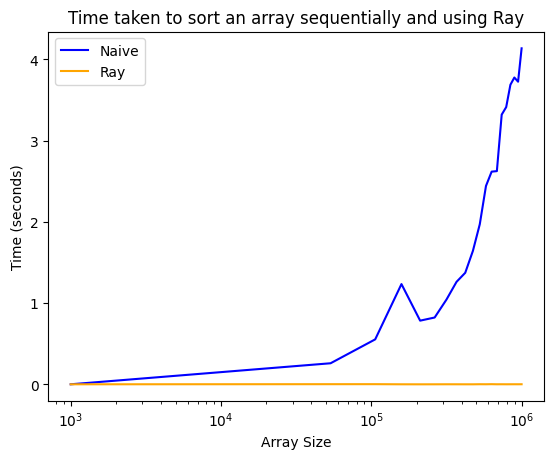

In [32]:
plt.plot(N, naive_times, label="Naive", color="blue")
plt.plot(N, ray_times, label="Ray", color="orange")
plt.xlabel("Array Size")
plt.ylabel("Time (seconds)")
plt.title("Time taken to sort an array sequentially and using Ray")
plt.legend()
plt.xscale("log")

## Part 7 - Compute Pi using Monte Carlo method (homework)
**Excercise:** Based on the previous example, create an actor-based system that can compute Pi using the Monte Carlo method. There should be one supervising actor and computing tasks/actors. As an output we expect to have numbers approaching to 3.14


![monte-carlo](img/monte_carlo_pi_sma.png)


In [33]:
def estimate_pi_naive(n: int, verbose: bool = False) -> float:
    inside_circle = 0
    for _ in range(n):
        x, y = random.uniform(-1, 1), random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            inside_circle += 1

    estimated_pi = 4 * inside_circle / n

    if verbose:
        print(f"Estimated Pi with {n} samples: {estimated_pi}")

    return estimated_pi

In [34]:
# implement here


@ray.remote
def sample(num_samples: int) -> int:
    hits = 0
    for _ in range(num_samples):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if x**2 + y**2 <= 1:
            hits += 1
    return hits


@ray.remote
class PiSupervisor:
    def __init__(self, num_samples: int, num_workers: int):
        self.num_samples = num_samples
        self.num_workers = num_workers
        self.total_hits = 0

    def compute_pi(self) -> float:
        sample_per_worker = self.num_samples // self.num_workers

        futures = [sample.remote(sample_per_worker) for _ in range(self.num_workers)]

        results = ray.get(futures)

        self.total_hits = sum(results)

        estimated_pi = 4 * self.total_hits / self.num_samples
        return estimated_pi


def estimate_pi_ray(num_samples: int, verbose: bool = False) -> float:
    num_workers = os.cpu_count()
    supervisor = PiSupervisor.remote(num_samples, num_workers)

    estimated_pi = ray.get(supervisor.compute_pi.remote())

    if verbose:
        print(f"Estimated Pi with {num_samples} samples: {estimated_pi}")

    return estimated_pi


In [35]:
# Samples
N = np.linspace(1_00, 100_000, num=10, dtype=int)

print(f"Actual Pi: {np.pi}")
for n in N:
    estimate_pi_ray(n, verbose=True)

Actual Pi: 3.141592653589793
Estimated Pi with 100 samples: 2.68
Estimated Pi with 11200 samples: 3.125714285714286
Estimated Pi with 22300 samples: 3.1503139013452914
Estimated Pi with 33400 samples: 3.1491017964071855
Estimated Pi with 44500 samples: 3.136449438202247
Estimated Pi with 55600 samples: 3.1445323741007196
Estimated Pi with 66700 samples: 3.149505247376312
Estimated Pi with 77800 samples: 3.1489974293059126
Estimated Pi with 88900 samples: 3.1411473565804275
Estimated Pi with 100000 samples: 3.14472


In [36]:
N = np.linspace(1_000, 1_000_000, num=100, dtype=int)

naive_times = np.zeros(len(N))
ray_times = np.zeros(len(N))

for i, n in enumerate(N):
    ray_times[i] = timeit(estimate_pi_ray, n)
    naive_times[i] = timeit(estimate_pi_naive, n)


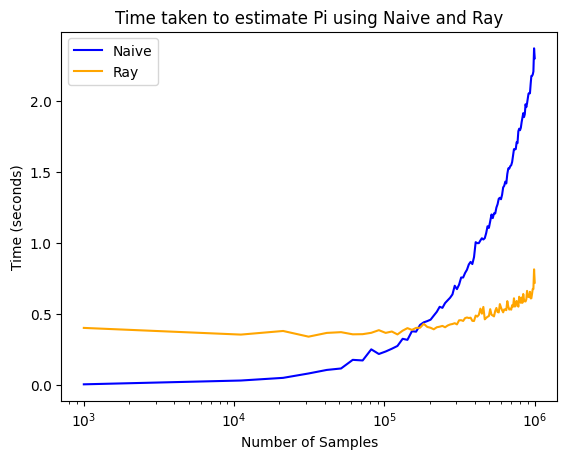

In [37]:
plt.plot(N, naive_times, label="Naive", color="blue")
plt.plot(N, ray_times, label="Ray", color="orange")
plt.xlabel("Number of Samples")
plt.ylabel("Time (seconds)")
plt.title("Time taken to estimate Pi using Naive and Ray")
plt.legend()
plt.xscale("log")

## Clean up  - Clean up the environemnt

**GOAL:** The goal of this exercise is to close the environment once you finish play with ray `ray.shutdown`.

In [38]:
# ray.shutdown()